## Load packages and data

In [1]:
%load_ext autoreload
%autoreload 2
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed. https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
import os
import glob
import joblib
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tensorflow.keras import Sequential
from tensorflow.keras import layers

# extra functions
from utility import generate_dataset, mean_absolute_error, mean_absolute_percentage_error, plot_result, report_results, normalise_data, vec2mat


In [2]:
path = Path("../Data/raw/AEMO/train/")
all_files = glob.glob(os.path.join(path, "*.csv"))
df_csv = pd.concat((pd.read_csv(f) for f in all_files))

## A. Short Term Prediction (2 hours)

In [3]:
def generate_dataset_with_price(df_csv, n_dim_in, n_dim_out, validation_ratio):
    
    X_demand, scaler_demand = normalise_data(df_csv, "TOTALDEMAND")
    X_price,  scaler_price  = normalise_data(df_csv, "RRP")
    
    M_demand = vec2mat(X_demand, n_dim_in, n_dim_out)
    M_price = vec2mat(X_demand, n_dim_in, n_dim_out)
    
    n_row, n_col = M_demand.shape
    
    X_demand = M_demand[:, 0:n_col-n_dim_out]
    y_demand = M_demand[:, n_col-n_dim_out:]
    
    X_price = M_price[:, 0:n_col-n_dim_out]
    y_price = M_price[:, n_col-n_dim_out:]
    
    X = np.concatenate((X_demand, X_price),axis=1)
    y = y_demand # target is the demand
    
    
    train_ratio = 1-validation_ratio
    n_train = int(n_row*train_ratio)

    # extract train data
    X_train = X[0:n_train][:]
    y_train = y[0:n_train][:]

    # extract test data
    X_val = X[n_train:][:]
    y_val = y[n_train:][:]
    
    return X_train, y_train, X_val, y_val, scaler_demand, scaler_price 

In [4]:
validation_ratio = 0.25
n_dim_in = 12 # 12 from demand + 12 from price, thus the input data matrix has 24 columns
n_dim_out = 4
X_train, y_train, X_val, y_val, scaler_demand, scaler_price  = generate_dataset_with_price(
    df_csv, n_dim_in, n_dim_out, validation_ratio)

In [5]:
print(f'Training samples: input {X_train.shape}, target {y_train.shape}')
print(f'Validation samples: input {X_val.shape}, target {y_val.shape}')

Training samples: input (26268, 24), target (26268, 4)
Validation samples: input (8757, 24), target (8757, 4)


In [6]:
# Init a model
model = Sequential(name = 'MLP_Demand_Prediction_Model_2hs')
# use the training data shape to set the input and output format
model.add(layers.Dense(100, input_shape = (X_train.shape[1],), activation='relu', name = 'Hidden_Layer'))
model.add(layers.Dense(y_train.shape[1], name ='Output_Layer'))
model.summary()

# Stop training when a monitored metric has stopped improving.
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Callback to save the Keras model or model weights at some frequency.
checkpoint_filepath =  './models/checkpoints/weights.best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, 
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 0)

model.compile(loss='mae', optimizer='Adam', metrics=['mae', 'mape', 'mse'])
 
print('# Fit model on training data with validtion on validation data')
# Model (weights) are saved at the end of every epoch, if it's the best seen so far.
history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs = 400,
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(X_val, y_val),
                    verbose=0,
                    callbacks=[model_checkpoint_callback, earlystop_callback])

print('The model(that are considered the best) are loaded back into the model.')
model.load_weights(checkpoint_filepath)
print('# Done')

Model: "MLP_Demand_Prediction_Model_2hs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer (Dense)         (None, 100)               2500      
_________________________________________________________________
Output_Layer (Dense)         (None, 4)                 404       
Total params: 2,904
Trainable params: 2,904
Non-trainable params: 0
_________________________________________________________________
# Fit model on training data with validtion on validation data
The model(that are considered the best) are loaded back into the model.
# Done


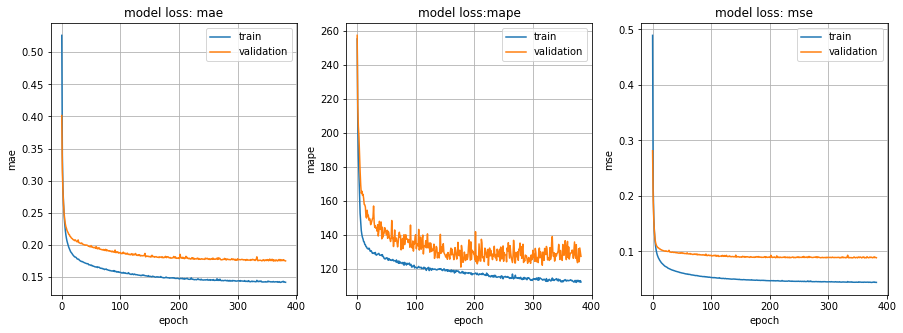

In [7]:
def plot_history(history):
    # summarize history for loss
    # Loss/MAE
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss: mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.grid(True)

    # MAPE
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mape'])
    plt.plot(history.history['val_mape'])
    plt.title('model loss:mape')
    plt.ylabel('mape')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.grid(True)

    # MSE
    plt.subplot(1, 3, 3)
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model loss: mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.grid(True)
    plt.show()
    
plot_history(history)

In [8]:
print("# Training results:")
y_train_pred = model.predict(X_train) 
mae_train , mape_train = report_results(y_train, y_train_pred, scaler = scaler_demand)
print("[MAE ]: %.4f"     % mae_train)
print("[MAPE]: %.4f %% " % mape_train)

# Training results:
[MAE ]: 121.9463
[MAPE]: 2.4675 % 


In [9]:
print("# Validation results:")
y_val_pred = model.predict(X_val) 
mae_val, mape_val= report_results(y_val, y_val_pred, scaler = scaler_demand)
print("[MAE ]: %.4f"     % mae_val)
print("[MAPE]: %.4f %% " % mape_val)

# Validation results:
[MAE ]: 150.8320
[MAPE]: 3.0570 % 


In [10]:
# save our MLP model
filename = './models/MLP.demand.short.p.TF' + '.hdf5'
model.save(filename)

In [11]:
del model, history

## B. Long Term Prediction (6 Hours)

In [12]:
validation_ratio = 0.25
n_dim_in = 24
n_dim_out = 12
X_train, y_train, X_val, y_val, scaler_demand, scaler_price  = generate_dataset_with_price(
    df_csv, n_dim_in, n_dim_out, validation_ratio)

print(f'Training samples: input {X_train.shape}, target {y_train.shape}')
print(f'Validation samples: input {X_val.shape}, target {y_val.shape}')

Training samples: input (26253, 48), target (26253, 12)
Validation samples: input (8752, 48), target (8752, 12)


In [13]:
# Init a model
model = Sequential(name = 'MLP_Demand_Prediction_Model_6hs')
model.add(layers.Dense(100, input_shape = (X_train.shape[1],), activation='relu', name = 'Hidden_Layer'))
model.add(layers.Dense(y_train.shape[1], name ='Output_Layer'))
model.summary()

# Stop training when a monitored metric has stopped improving.
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Callback to save the Keras model or model weights at some frequency.
checkpoint_filepath =  './models/checkpoints/weights.best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, 
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 0)

model.compile(loss='mae', optimizer='Adam', metrics=['mae', 'mape', 'mse'])
 
print('# Fit model on training data with validtion on validation data')
# Model (weights) are saved at the end of every epoch, if it's the best seen so far.
history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs = 400,
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(X_val, y_val),
                    verbose=0,
                    callbacks=[model_checkpoint_callback, earlystop_callback])

print('The model(that are considered the best) are loaded back into the model.')
model.load_weights(checkpoint_filepath)
print('# Done')

Model: "MLP_Demand_Prediction_Model_6hs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer (Dense)         (None, 100)               4900      
_________________________________________________________________
Output_Layer (Dense)         (None, 12)                1212      
Total params: 6,112
Trainable params: 6,112
Non-trainable params: 0
_________________________________________________________________
# Fit model on training data with validtion on validation data
The model(that are considered the best) are loaded back into the model.
# Done


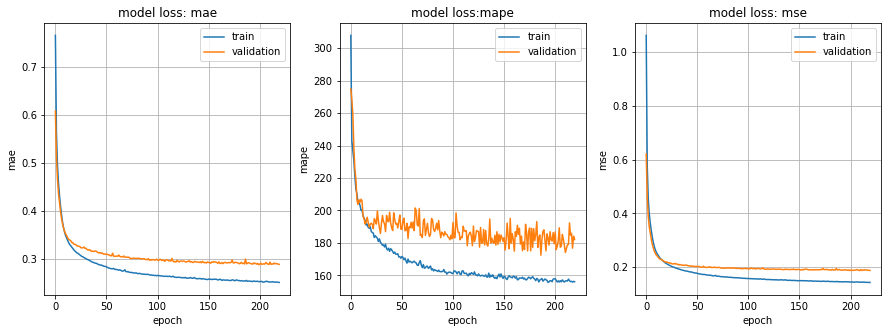

In [14]:
plot_history(history)

In [15]:
print("# Training results:")
y_train_pred = model.predict(X_train) 
mae_train , mape_train = report_results(y_train, y_train_pred, scaler = scaler_demand)
print("[MAE ]: %.4f"     % mae_train)
print("[MAPE]: %.4f %% " % mape_train)

print("\n # Validation results:")
y_val_pred = model.predict(X_val) 
mae_val, mape_val= report_results(y_val, y_val_pred, scaler = scaler_demand)
print("[MAE ]: %.4f"     % mae_val)
print("[MAPE]: %.4f %% " % mape_val)

# Training results:
[MAE ]: 216.7163
[MAPE]: 4.4052 % 

 # Validation results:
[MAE ]: 247.8143
[MAPE]: 5.0816 % 


In [16]:
# save our MLP model
filename = './models/MLP.demand.long.p.TF' + '.hdf5'
model.save(filename)

In [17]:
del model, history

In [18]:
# save our scalar function 
filename = './models/scaler_demand.p.joblib' + '.z'
joblib.dump(scaler_demand, filename)

filename = './models/scaler_price.p.joblib' + '.z'
joblib.dump(scaler_price, filename)

['./models/scaler_price.p.joblib.z']

## C. Test the Model

In [19]:
filename = './models/MLP.demand.short.p.TF' + '.hdf5'
model_ShortTerm = tf.keras.models.load_model(filename)
model_ShortTerm.summary() # check the information

Model: "MLP_Demand_Prediction_Model_2hs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer (Dense)         (None, 100)               2500      
_________________________________________________________________
Output_Layer (Dense)         (None, 4)                 404       
Total params: 2,904
Trainable params: 2,904
Non-trainable params: 0
_________________________________________________________________


In [20]:
filename = './models/MLP.demand.long.p.TF' + '.hdf5'
model_LongTerm = tf.keras.models.load_model(filename)
model_LongTerm.summary() # check the information

Model: "MLP_Demand_Prediction_Model_6hs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer (Dense)         (None, 100)               4900      
_________________________________________________________________
Output_Layer (Dense)         (None, 12)                1212      
Total params: 6,112
Trainable params: 6,112
Non-trainable params: 0
_________________________________________________________________


### get the test data ready

In [22]:
path = Path("../Data/raw/AEMO/test/")
all_files = glob.glob(os.path.join(path, "*.csv"))
df_csv = pd.concat((pd.read_csv(f) for f in all_files))

##  test model

In [23]:
def generate_test_data(df_csv, n_dim_in, n_dim_out, scaler_list = [scaler_demand, scaler_price]):
    data_demand = df_csv["TOTALDEMAND"].to_numpy().reshape(-1, 1) # extract the column
    X_demand = scaler_list[0].transform(data_demand) # normalise the values with statistic we learned from training data
    M_demand = vec2mat(X_demand, n_dim_in, n_dim_out)
    
    data_demand = df_csv["RRP"].to_numpy().reshape(-1, 1) # extract the column
    X_price = scaler_list[1].transform(data_demand) # normalise the values with statistic we learned from training data
    M_price = vec2mat(X_demand, n_dim_in, n_dim_out)
    
    n_row, n_col = M_demand.shape
    X_demand = M_demand[:, 0:n_col-n_dim_out]
    y_demand = M_demand[:, n_col-n_dim_out:]
    
    X_price = M_price[:, 0:n_col-n_dim_out]
    y_price = M_price[:, n_col-n_dim_out:]
    
    X = np.concatenate((X_demand, X_price),axis=1)
    y = y_demand # target is the demand
    return X, y

In [24]:
def test_model(model, df_csv, scaler_list = [scaler_demand, scaler_price]):
    # get the input and ouput shape from our model
    n_dim_in = model.input_shape[1]
    n_dim_out = model.output_shape[1]
    # the salar function is from our training dataset.
    X_test, y_test = generate_test_data(df_csv, n_dim_in/2, n_dim_out, scaler_list) # two scaler functions

    print(f'Test samples: input {X_test.shape}, target {y_test.shape}')
    
    print("# Test results:")
    y_pred = model.predict(X_test)
    mae  , mape  = report_results(y_test, y_pred, scaler= scaler_list[0])
    print("[MAE ]: %.4f"     % mae)
    print("[MAPE]: %.4f %% " % mape)
    
    return X_test, y_test, y_pred

#### Test the short term prediction model

Test samples: input (6993, 24), target (6993, 4)
# Test results:
[MAE ]: 135.0393
[MAPE]: 2.8672 % 


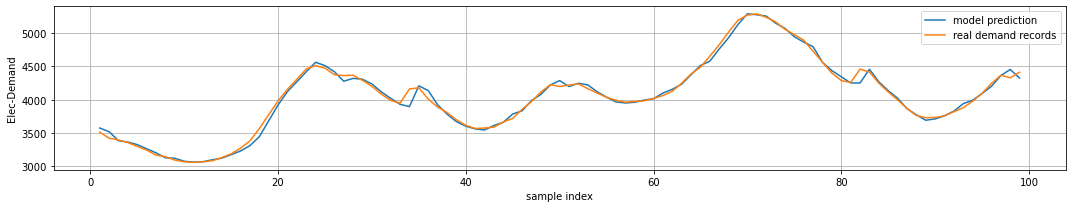

In [25]:
X_test, y_test, y_pred = test_model(model_ShortTerm, df_csv, scaler_list = [scaler_demand, scaler_price])
plot_result(y_pred[:, 0], y_test[:, 0], scaler_demand, length=100)

#### Test the long term prediction model


Test samples: input (6973, 48), target (6973, 12)
# Test results:
[MAE ]: 259.1755
[MAPE]: 5.6163 % 


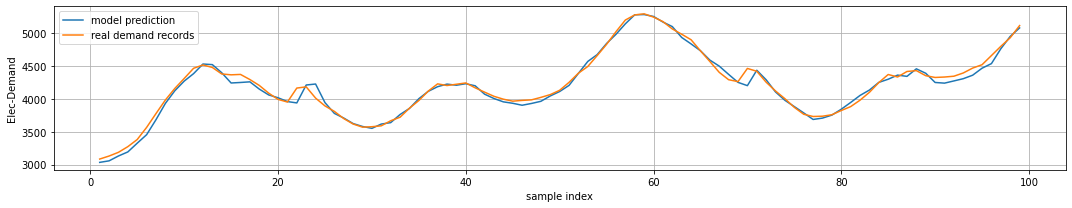

In [26]:
X_test, y_test, y_pred = test_model(model_LongTerm, df_csv, scaler_list = [scaler_demand, scaler_price])
plot_result(y_pred[:, 0], y_test[:, 0], scaler_demand, length=100)